### FNO Library

In [ ]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import datetime
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [ ]:
import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation 
discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
# from utilities3 import *

# from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

### LSTM

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
# from utilities3 import *

torch.manual_seed(0)
np.random.seed(0)


class LSTM(nn.Module):
    def __init__(self, layer, width, x_size=512):
        super(LSTM, self).__init__()

        self.num_layers = layer
        self.hidden_size = width
        self.x_size = x_size

        self.lstm = nn.LSTM(input_size=x_size, hidden_size=width, num_layers=layer)

        self.fc = nn.Linear(width, x_size//2)

    def forward(self, x, h=None, c=None):

        T_size = x.shape[0]
        batch_size = x.shape[1]

        # h, c (num_layers * num_directions, batch, hidden_size)
        if h ==None:
            h, c = self.init_hidden(shape=(self.num_layers, batch_size, self.hidden_size), device=x.device)

        #input (seq_len, batch, input_size)
        out, (h, c) = self.lstm(x.view(T_size, batch_size, self.x_size), (h, c))

        out = self.fc(out)

        return out, h, c

    def init_hidden(self, shape, device):
        return (torch.zeros(shape, device=device),
                torch.zeros(shape, device=device))

    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

### Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################
#  Load Data
################################################################
obs_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_obs_data0218.pt')
sys_data = torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_sys_data0218.pt')
obs_data.shape

torch.Size([1200, 5001, 101])

In [ ]:
subsampling = 50
obs_data = obs_data[:, ::subsampling, :]
sys_data = sys_data[:, ::subsampling, :]

In [ ]:
nt = sys_data.shape[1]
nx = sys_data.shape[2]

print(nt)
print(nx)

101
101


In [ ]:
initial = obs_data[:,:-1:,:]
print('initial, initial shape', initial.shape)
# initial = initial[:, ::10, :]
# initial = torch.repeat_interleave(initial, 10, dim=1)
# print('initial shape', initial.shape)

initial, initial shape torch.Size([1200, 100, 101])


In [ ]:
boundary = sys_data[:, 1:, -1:]
print('initial boundary shape', boundary.shape)
boundary = boundary.repeat(1,1,nx)
print('boundary shape', boundary.shape)

initial boundary shape torch.Size([1200, 100, 1])
boundary shape torch.Size([1200, 100, 101])


In [ ]:
# initial = obs_data[:,:-1:,:]
# # initial_pturb = initial+ 0.05* torch.rand(initial.shape) 

# boundary = sys_data[:, 1:, -1:].repeat(1,1,nx) #boundary measurement at the right

input = torch.cat([initial, boundary], dim=-1)
output = obs_data[:,1:,:]
print(input.shape, output.shape)

torch.Size([1200, 100, 202]) torch.Size([1200, 100, 101])


### Train Model

In [ ]:
Ntrain = 1000 # training instances
Ntest = 200 # testing instances

nt = input.shape[1] 
nx = output.shape[2] 

t = 10
T_iter = nt//t

ntrain = Ntrain * T_iter * t
ntest = Ntest * T_iter * t

s =  nx

batch_size = 20
learning_rate = 0.001

epochs = 200
step_size = 10
gamma = 0.5
ep_print = 1

layer = 1
width = 1000

print('layer, width, batch_size, learning_rate, epochs', layer, width, batch_size, learning_rate, epochs)

layer, width, batch_size, learning_rate, epochs 1 1000 20 0.001 200


In [ ]:
x_train = input[:Ntrain, :, :].reshape((Ntrain, T_iter, t, nx*2))
y_train = output[:Ntrain, :, :].reshape((Ntrain, T_iter, t, nx))
print(x_train.shape)
print(y_train.shape)
x_test = input[-Ntest:, :, :].reshape((Ntest, T_iter, t, nx*2))
y_test = output[-Ntest:, :, :].reshape((Ntest, T_iter, t, nx))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

torch.Size([1000, 10, 10, 202])
torch.Size([1000, 10, 10, 101])


In [ ]:
model = LSTM(layer=layer, width=width, x_size=nx*2).cuda()

print(model.count_params())

4917101


In [ ]:
########### training
myloss = LpLoss(size_average=False)
# y_normalizer.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

error = np.zeros((epochs+1, 2))
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    train_overall = 0
    train_traj = np.zeros(T_iter, )

    for xx, yy in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        h = None
        c = None
        y_pred = torch.zeros_like(yy).to(device)

        for i in range(0, T_iter):

            # xx,yy: (batch, T_iter, t, s)
            x = xx[:, i, :, :].permute(1,0,2) # (t, batch, s)
            y = yy[:, i, :, :].permute(1,0,2) # (t, batch, s)

            im, h, c = model(x, h, c)

            h = h.detach()
            c = c.detach()

            y_pred[:, i, :, :] = im.permute(1,0,2)

            optimizer.zero_grad()
            
            loss = myloss(im.reshape(-1, s), y.reshape(-1, s))
            loss.backward()
            optimizer.step()

            train_traj[i] += loss.item()
            train_l2 += loss.item()
                    
        #mse = F.mse_loss(y_pred.reshape(batch_size, -1), yy.reshape(batch_size, -1), reduction='mean')
        #train_mse += mse.item()
        loss_overall = myloss(y_pred.reshape(batch_size, -1, s), yy.reshape(batch_size, -1, s))
        train_overall += loss_overall.item()
        

    if ep % ep_print == ep_print-1:
        test_l2 = 0
        test_traj = np.zeros(T_iter, )
        test_overall = 0
        model.eval()
        with torch.no_grad():
            for xx, yy in test_loader:
                xx = xx.to(device)
                yy = yy.to(device)
                h = None
                c = None
                for i in range(0, T_iter):
                    # xx,yy: (batch, T_iter, t, s)
                    x = xx[:, i, :, :].permute(1,0,2) # (t, batch, s)
                    y = yy[:, i, :, :].permute(1,0,2) # (t, batch, s)

                    im, h, c = model(x, h, c)
                    y_pred[:, i, :, :] = im.permute(1,0,2)

                    loss = myloss(im.reshape(-1, s), y.reshape(-1, s))
                    test_traj[i] += loss.item()
                    test_l2 += loss.item()
                loss_overall = myloss(y_pred.reshape(batch_size, -1, s), yy.reshape(batch_size, -1, s))
                test_overall += loss_overall.item()
        

        t2 = default_timer()
        
        train_l2 = train_l2 / Ntrain /T_iter / t
        train_traj = train_traj / Ntrain / t
        train_overall = train_overall  / Ntrain
        test_l2 = test_l2 / (T_iter*Ntest*t)
        test_traj = test_traj / (Ntest*t)
        test_overall = test_overall/Ntest
        # train_mse /= Ntrain

        print(ep, t2 - t1, train_l2, train_overall, test_l2, test_overall)
        # print(ep, t2 - t1, train_l2, train_traj, test_l2, test_traj)
        error[ep] = [train_l2, train_overall]

    scheduler.step()

0 2.563030550999997 0.7134118862533569 0.8597345314025879 0.5785524787902832 0.7732077074050904
1 2.4446555729999773 0.5518864921188354 0.7509247741699219 0.5485629358291626 0.7391623878479003
2 2.449090872000056 0.5129185518264772 0.7173122358322144 0.4946664346694946 0.6966812086105346
3 2.4464897760000213 0.48894553600311275 0.6915366878509521 0.4897465686798096 0.6961387252807617
4 2.446656648000044 0.4722554892730713 0.6786333589553833 0.4679067226409912 0.6726330232620239
5 2.4459364099999448 0.479601750869751 0.6828749237060547 0.46675243549346923 0.6762368297576904
6 2.4859193480000386 0.4668307600402832 0.6681671371459961 0.4544430501937866 0.6569189310073853
7 2.5125912629999902 0.45240166847229 0.651326174736023 0.4536450826644898 0.658213963508606
8 2.4472752089999403 0.45246119943618773 0.6549319276809692 0.4666043882369995 0.6565949964523315
9 2.4610824210000146 0.4506555634307861 0.6494614953994751 0.4458822639465332 0.6431608676910401
10 2.4502929090000407 0.43404716224

KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(), 'model/lstm_reactor')
model1 = LSTM(layer=layer, width=width, x_size=nx*2).cuda()
model1.load_state_dict(torch.load('model/lstm_reactor'))

<All keys matched successfully>

In [ ]:
T_in = 0
T_out = 50
T_warmup = 15
T_iter = (T_out-T_in)
print(T_out, T_warmup)

# dataloader = MatReader(PATH_DATA)
# x_test = dataloader.read_field('u')[-1, T_in, ::sub].reshape(1, s)
# y_test = dataloader.read_field('u')[-1, T_in:T_out, ::sub].reshape(T_iter, s)

x_test = x_test.reshape((Ntest, nt, 2*nx))
y_test = y_test.reshape((Ntest, nt, nx))

print(x_test.shape)
print(y_test.shape)

50 15
torch.Size([200, 50, 202])
torch.Size([200, 50, 101])


In [ ]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)

model.eval()
ep_print = 1

with torch.no_grad():
    pred = torch.zeros(Ntest, T_iter, s)
    pred = pred.cuda()
    errors = torch.zeros(Ntest, T_iter, )
    error_overall = 0
    index = 0
    h = None
    c = None
    
    #no warm up
    t1 = default_timer()
    for x, y in test_loader:
        x = x.cuda()
        y = y.cuda()

        x_in = x[:, 0:1, :]
        pred[index, 0, :] = x_in[:, :, 0:nx].reshape(s)
        
        for t in range(1, T_iter):
          out, h, c = model(x_in, h, c)
          pred[index, t, :] = out.reshape(s)

          x_in = x[:, t+1:t+2, :]
          if(t>T_warmup):
            x_in[:, :, 0:nx] = out.reshape(1, 1, s)

          l2 = myloss(out.view(1, -1), y[:,t,:].view(1, -1)).item()
          errors[index, t] = l2
        
        total_l2 = myloss(pred[index, T_warmup:].view(1, -1), y[:, T_warmup:].view(1, -1)).item()
        error_overall += total_l2
        
        # if index % ep_print == ep_print-1:
        #     print(index, l2)
        index = index + 1
    t2 = default_timer()

    print(error_overall/Ntest, (t2-t1)/Ntest)

#     #warm up
#     pred2 = torch.zeros(T_iter, s)
#     errors2 = torch.zeros(T_iter, )
#     index = 0
#     out = x_test.cuda()
#     h = None
#     c = None
#     for y, in test_loader:
#         x_in = out.view(1, 1, s)
#         y = y.cuda()

#         out, h, c = model(x_in, h, c)
#         pred2[index] = out.reshape(1,s)

#         l2 = myloss(out.view(1, -1), y.view(1, -1)).item()
#         errors2[index] = l2
#         if index % ep_print == ep_print-1:
#             print(index, l2)
#         index = index + 1

#         if index+T_in < T_warmup:
#             out = y

# scipy.io.savemat(path_pred, mdict={'pred': pred.cpu().numpy(), 'pred2': pred2.cpu().numpy(), 'y': y_test.cpu().numpy(),})

0.5955810564011336 0.02376598708500069


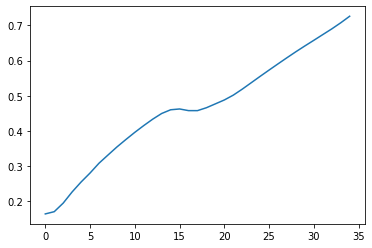

In [ ]:
plt.plot(errors[:, T_warmup:].mean(dim=0))